## Imports

In [1]:
import numpy as np
from numpy import pi as π
import numba
import matplotlib.pyplot as plt
import scipy as sp

We will use a Gaussian potential which has the form
$$
V(x)=-V_0\exp{\left[-\frac{(x-x_0)^2}{2\Delta^2}\right]}
$$

In [2]:
def V_gaussian(x,
               V0 = 3.0,    # amplitude (depth of well)
               x0 = 0.0,    # center of well
               Δ  = 1.5,    # width of well
              ):
    return -V0*np.exp(-(x - x0)**2 / (2 * Δ**2))

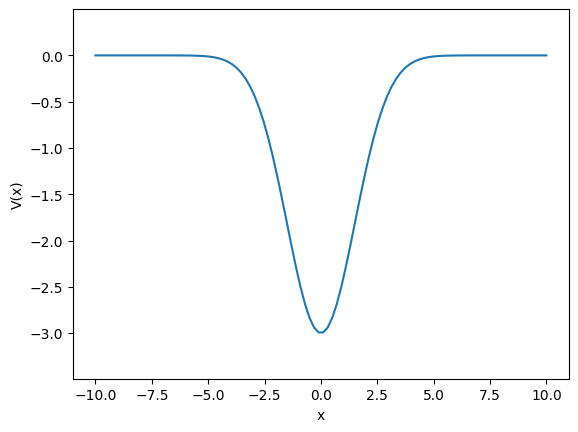

In [3]:
X = np.linspace(-10,10,100)
V = np.array([V_gaussian(x) for x in X])

plt.xlabel('x')
plt.ylabel('V(x)')
plt.ylim( np.min(V)-0.5, np.max(V)+0.5 )
plt.plot(X,V)

To solve the TISE $-\frac{\hbar^2}{2m}\frac{d^2}{dx^2}\psi(x) + V(x)\psi(x) = E\psi(x)$, we will use a central difference formula to compute the second derivative of $\psi(x)$:
$$
\frac{d^2}{dx^2}\psi(x) = \frac{\psi(x+\delta_x) + \psi(x-\delta_x) - 2\psi(x)}{\delta_x^2}
$$

So that when we discretize $\psi(x_n)=\psi(n\delta_x)\equiv\psi_n$ (where $\delta_x$ is the spacing between points), we can express the TISE as
$$
\begin{align}
-\frac{\hbar^2}{2m\delta_x^2}\left(\psi_{n+1} + \psi_{n-1} - 2\psi_n\right) + V_n\psi_n &= E_n\psi_n \\
\left(\frac{\hbar^2}{m\delta_x^2} + V_n\right)\psi_n -\frac{\hbar^2}{2m\delta_x^2}\left(\psi_{n+1} + \psi_{n-1}\right) &= E_n\psi_n \\
\begin{pmatrix}
\frac{\hbar^2}{m\delta_x^2} + V_1 & 0 & \cdots & 0 \\
0 & \frac{\hbar^2}{m\delta_x^2} + V_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \frac{\hbar^2}{m\delta_x^2} + V_N
\end{pmatrix}
-\frac{\hbar^2}{2m\delta_x^2}\begin{pmatrix}
0 & 1 & 0 & \cdots & 0 \\
1 & 0 & 1 & \cdots & 0 \\
0 & 1 & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 1 & 0
\end{pmatrix}&= E_n\psi_n
\end{align}
$$

Where $N$ is the number of points on our grid and we define $\alpha\equiv\frac{\hbar^2}{2m\delta_x^2}$. We are now left with the eigenvalue problem
$$
\begin{pmatrix}
2\alpha+V_1 & -\alpha & 0 & \cdots & 0 \\
-\alpha & 2\alpha+V_2 & -\alpha & \cdots & 0 \\
0 & -\alpha & 2\alpha + V_3 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & -\alpha & 2\alpha + V_N
\end{pmatrix}\psi_n
=
E_n\psi_n
$$

We could solve this straightforward using `sp.linalg.eigh` with no issues, but instead we will use `sp.linalg.eigh_tridiagonal` since our matrix follows a tridiagonal structure.

In [4]:
def solve_tise(V,X,ħ=1,m=1,numvals=None):
    δx = X[1] - X[0]
    N = len(X)
    α  = ħ**2 / (2*m*δx**2)
    
    A = np.linspace(-α,-α,N-1)
    
    diag     = 2*α + V
    off_diag = -α * np.ones(N-1)

    # if numvals is entered, return that number of values
    if numvals == None:
        E,Ψ = sp.linalg.eigh_tridiagonal(diag,off_diag)
    else:
        E,Ψ = sp.linalg.eigh_tridiagonal(diag,off_diag,select='i',select_range=(0,numvals))
    
    Ψ /= np.sqrt(δx) # normalize Ψ
    
    return E,Ψ

In [5]:
N  = 1000
X,δx  = np.linspace(-15,15,N,retstep=True)
V  = np.array([V_gaussian(x) for x in X])

E,Ψ  = solve_tise(V,X,numvals=4)

-0.1701257522516521

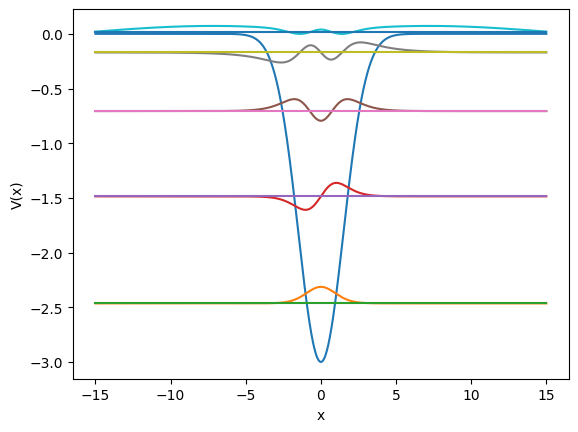

In [6]:
plt.xlabel('x')
plt.ylabel('V(x)')
plt.plot(X,V)
for i,ϵ in enumerate(E):
    plt.plot(X, 0.2*Ψ[:,i] + ϵ)
    plt.plot(X, ϵ * np.ones(N))
E[-2]

## Convergence Test

We are trying to find the smallest value of the grid spacing $\delta_x$ of which the highest energy level converges (or equivalently, the largest number of grid points $N$)

In [7]:
Ns = np.linspace(100,20000,1000,dtype=int) # range of grid points to try
Σ = np.empty(len(Ns)) # array to hold highest energy levels at N grid points

for i,N in enumerate(Ns):
    X,δx  = np.linspace(-10,10,N,retstep=True) # create grid of N points
    V  = np.array([V_gaussian(x) for x in X]) 
    
    E,Ψ  = solve_tise(V,X,numvals=4) # solve TISE for this iteration of Ns

    Σ[i] = E[-2] # store highest energy level

Now that we have a mapping between a highest energy level and a number of grid points, we can find the number of grid points $\hat{N}$ where the energy level is changing very slowly. In a more formal sense, we are searching for the smallest $N\equiv\hat{N}$ such that
$$
|E(N) - E(N-1)| < \epsilon
$$
Where $E(N)$ is the highest energy level with a number of grid points $N$, and $\epsilon$ is a value for the difference that we choose to be acceptable.

In [8]:
ϵ = 1e-6 # choose difference limit
for i in range(1,len(Σ)):
    δ = abs(Σ[i] - Σ[i-1])
    if δ < ϵ:
        N̂ = i
        break

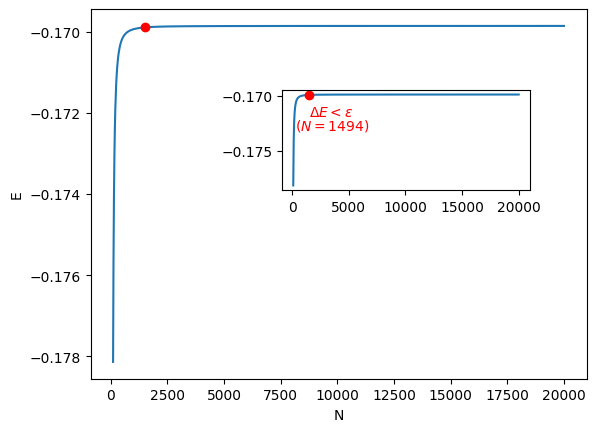

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
plt.scatter(Ns[N̂], Σ[N̂], color='red',zorder=1)
plt.plot(Ns,Σ,zorder=0)
plt.xlabel('N')
plt.ylabel('E')

# this is an inset axes over the main axes
isa = inset_axes(ax, 
                    width="50%",
                    height=1.0, 
                    loc=1,
                    bbox_to_anchor=(-0.1,-0.2,1,1),
                    bbox_transform=ax.transAxes)
#plt.xlim(1800,2500)
#plt.ylim(0.0475,0.0485)
plt.annotate(r'$\Delta E<\epsilon$', (Ns[N̂], Σ[N̂]), xycoords='data', xytext=(0,-15), textcoords='offset points', color='red')
plt.annotate(f'$(N={int(Ns[N̂])})$', (Ns[N̂], Σ[N̂]), xycoords='data', xytext=(-10,-25), textcoords='offset points', color='red')
plt.scatter(Ns[N̂], Σ[N̂], color='red',zorder=1)
plt.plot(Ns,Σ,zorder=0)

Ideally, we will choose an $N=2^n$ for some integer $n$. In this case it would be ideal to choose $N=2048$

## Multiple Wells

Now we will try this on a potential with multiple wells. This can be done by using a bunch of Gaussian potentials separated by some distance $a$.
$$
\sum_{m=0}^{L}V(x-ma) = V(x) + V(x-a) + V(x-2a) + \cdots
$$

Where $L\equiv N_La$ is the width of our lattice and $N_L$ is the number of lattice points

In [10]:
N   = 2048
N_L = 2
a = 2
V0 = 40
width = a/10

X = np.linspace(-2*a, a*N_L + a, N)
V_x = lambda x: sum([V_gaussian(x - m*a, V0=V0, Δ=width) for m in range(N_L)])
V = np.array([V_x(x) for x in X])

E,Ψ  = solve_tise(V,X)

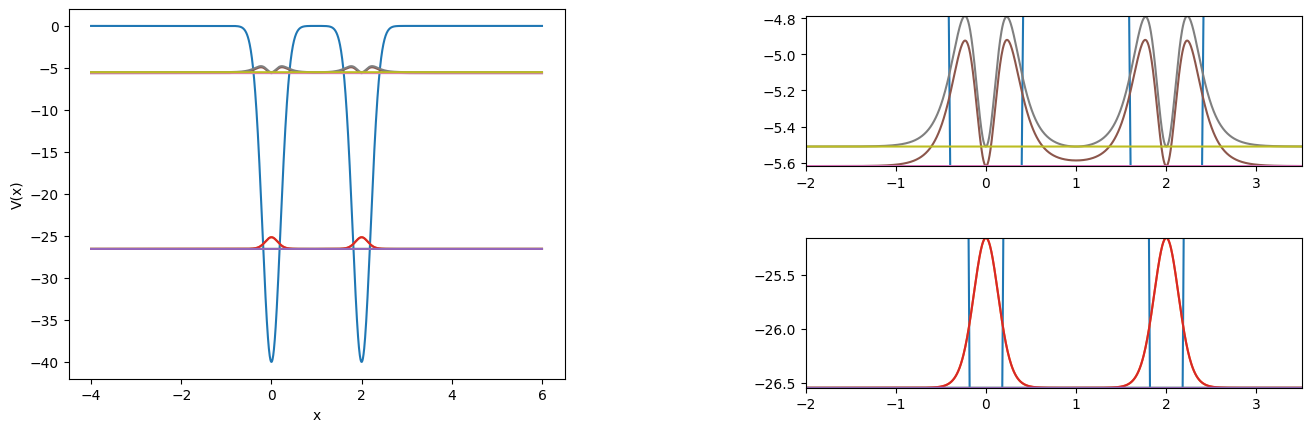

In [11]:
num_neg_energies = len([ϵ for ϵ in E if ϵ < 0])

def plot_data(X,V,E,Ψ,xlabel='',ylabel=''):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(X,V)
    for i,ϵ in enumerate(E):
        if ϵ > 0:
            continue
        #plt.plot(X, 0.2*Ψ[:,i] + ϵ)
        plt.plot(X, np.abs(Ψ[:,i])**2 + ϵ)
        plt.plot(X, ϵ * np.ones(N))
    
fig = plt.figure()
ax = fig.add_subplot()
plot_data(X,V,E,Ψ,'x','V(x)')

# zoomed limits
xlim_l = -2.0
xlim_r = 3.5

# zoomed figure 1
ylim_l = min([min(np.abs(Ψ[:,n])**2 + E[n]) for n in range(num_neg_energies//2, num_neg_energies)])
ylim_r = max([max(np.abs(Ψ[:,n])**2 + E[n]) for n in range(num_neg_energies//2, num_neg_energies)])
isa = inset_axes(ax,width='100%',height=1.5,loc=1,bbox_to_anchor=(1.5,0,1,1),bbox_transform=ax.transAxes)
plt.xlim(xlim_l,xlim_r)
plt.ylim(ylim_l,ylim_r)
plot_data(X,V,E,Ψ)
    
# zoomed figure 2
ylim_l = min([min(np.abs(Ψ[:,n])**2 + E[n]) for n in range(num_neg_energies//2)])
ylim_r = max([max(np.abs(Ψ[:,n])**2 + E[n]) for n in range(num_neg_energies//2)])
isa = inset_axes(ax,width='100%',height=1.5,loc=1,bbox_to_anchor=(1.5,-0.6,1,1),bbox_transform=ax.transAxes)
plt.xlim(xlim_l, xlim_r)
plt.ylim(ylim_l, ylim_r)
plot_data(X,V,E,Ψ)

In [12]:
print(E[0], E[1])
print(E[0] - E[1])

-26.54585920091023 -26.545631193517888
-0.00022800739234085654
